In [33]:
import argparse, time
import numpy as np
import pandas as pd
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl import DGLGraph
from dgl.data import register_data_args, load_data
from tqdm import tqdm
from datetime import datetime
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from pytorch_classification.utils import Bar, AverageMeter
%matplotlib inline

from models.GCN import Net
from torch.utils.data import DataLoader
from dataUtils import loadEnergyData, processData, energyDataset
from modelUtils import saveCheckpoint, loadCheckpoint, plotPredVsTrue,dotDict

In [2]:
processed_dir = "data/"
validation_range = ["2014-10-01 00:00:00", "2014-12-31 23:00:00"]
validation_range = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in validation_range]

In [54]:
args = dotDict({      
        # model params
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "epochs": 100,
        "batch_size": 64,
        "lr": .001,
        "model_name": "DGL_GCN.pth",
        "steps":5
})

In [4]:
class DGL_EnergyDataset(Dataset):
    def __int__(self,args=None,processing_function=None):
        self.args = args
        self.processing_function=processing_function
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self,index):
        return self.inputs[index],self.targets[index]
    
    def process(self,df):
        #df = self.processing_function(df)
        #print("Processed Data")
        grouped = df.groupby('time')
        inputs = []
        targets = []
        for time, group in tqdm(grouped):
            group.node = group.node.astype('int64')
            group = group.sort_values('node')


            node_targets = group.load.values
            #print(group.loc[group.time==time,['solar_ecmwf','wind_ecmwf','holiday','hour','dow','month','year',
                                          #'season','country','voltage']].values)
            node_features = group.loc[group.time==time,['solar_ecmwf','wind_ecmwf','holiday','hour','dow','month','year',
                                          'season','country','voltage']].values

            node_features = torch.from_numpy(np.array(node_features))
            node_targets = torch.from_numpy(np.array(node_targets))
           
            inputs.append(node_features)
            targets.append(node_targets)
        #print(torch.stack(inputs).transpose(0,1).shape) 
        #print(torch.stack(inputs).shape)
        self.inputs,self.targets = torch.stack(inputs), \
        torch.stack(targets)
        self.inputs = self.inputs.type(torch.FloatTensor)
        self.targets = self.targets.type(torch.FloatTensor)
        

In [5]:
def getDatasets(energy_demand, validation_range):
    energy_demand['time'] = pd.to_datetime(energy_demand['time'], format='%Y-%m-%d %H:%M:%S')
    
    # extract validation and training sets
    train_df = energy_demand[energy_demand['time'] < validation_range[0]].reset_index(drop = True)
    val_df = energy_demand[(energy_demand['time'] >= validation_range[0]) & 
                           (energy_demand['time'] <= validation_range[1])].reset_index(drop = True)
    
    train_dataset = DGL_EnergyDataset()
    valid_dataset = DGL_EnergyDataset()
    train_dataset.process(train_df)
    valid_dataset.process(val_df)
    #print(valid_dataset)
    #train_dataset = train_dataset.type(torch.FloatTensor)
    #valid_dataset = valid_dataset.type(torch.FloatTensor)


    return train_dataset,valid_dataset

In [36]:
#load data
energy_demand, adj_mat = loadEnergyData(processed_dir, incl_nodes = 300, partial = False)
#bacis preprocessing and normalization
energy_demand = processData(energy_demand)
#train_dataset,val_dataset = getDatasets(energy_demand)
#train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)

In [37]:
energy_demand

,node,time,solar_ecmwf,wind_ecmwf,holiday,hour,dow,month,year,season,country,voltage,load
0,1,2012-01-01 00:00:00,0.0,0.0284,1,0.000000,1.000000,0.0,0.0,1.0,1.0,0.0,0.007619
1,1,2012-01-01 01:00:00,0.0,0.0336,1,0.043478,1.000000,0.0,0.0,1.0,1.0,0.0,0.007149
2,1,2012-01-01 02:00:00,0.0,0.0392,1,0.086957,1.000000,0.0,0.0,1.0,1.0,0.0,0.006711
3,1,2012-01-01 03:00:00,0.0,0.0424,1,0.130435,1.000000,0.0,0.0,1.0,1.0,0.0,0.006343
4,1,2012-01-01 04:00:00,0.0,0.0475,1,0.173913,1.000000,0.0,0.0,1.0,1.0,0.0,0.006150
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7891195,300,2014-12-31 19:00:00,0.0,0.2457,0,0.826087,0.333333,1.0,1.0,1.0,0.5,0.0,0.013321
7891196,300,2014-12-31 20:00:00,0.0,0.2605,0,0.869565,0.333333,1.0,1.0,1.0,0.5,0.0,0.012708
7891197,300,2014-12-31 21:00:00,0.0,0.2924,0,0.913043,0.333333,1.0,1.0,1.0,0.5,0.0,0.012363
7891198,300,2014-12-31 22:00:00,0.0,0.2836,0,0.956522,0.333333,1.0,1.0,1.0,0.5,0.0,0.013236


In [38]:
train_dataset,val_dataset = getDatasets(energy_demand,validation_range)

  0%|          | 0/24096 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
100%|██████████| 2208/2208 [00:07<00:00, 302.15it/s]


In [51]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


In [40]:
num_of_nodes = train_dataset.inputs.shape[1]
print(num_of_nodes)

300


In [41]:
edge_df = pd.read_csv(processed_dir+'network_edges.csv')
#just try partial data
#edge_df = edge_df[edge_df.fromNode<20]
# edge_df = edge_df[edge_df.toNode <20]
edge_df

,fromNode,toNode,X,Y,numLines,limit,length
0,344,559,0.012030,83.125520,1,1260.0,51.227041
1,344,561,0.015980,62.578223,1,1490.0,34.002397
2,344,336,0.013212,75.687824,2,0.0,25.467094
3,344,566,0.013770,72.621641,1,1320.0,34.755553
4,344,356,0.021120,47.348485,1,0.0,61.628358
...,...,...,...,...,...,...,...
2151,1364,1360,0.073660,13.575889,1,0.0,63.246338
2152,1362,1363,0.004805,208.116545,2,0.0,9.461581
2153,1362,1368,0.076860,13.010669,1,0.0,51.718657
2154,1362,1361,0.009610,104.058273,1,0.0,15.198719


In [45]:
#g = DGLGraph()
#g.add_nodes(num_of_nodes)
#g.add_edges(edge_df.fromNode-1,edge_df.toNode-1)
def build_energy_demand_graph(df,edge_df):
    node = list(list(map(int,set(df["node"]))))
    edge_df = edge_df[edge_df.fromNode.isin(node)& edge_df.toNode.isin(node)]
    g = DGLGraph()
    g.add_nodes(max(node))
    src = tuple(edge_df["fromNode"]-1)
    dst = tuple(edge_df["toNode"]-1)
    g.add_edges(src,dst)
    return(g)

In [46]:
g=build_energy_demand_graph(energy_demand,edge_df)

In [47]:
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

In [49]:
net = Net()
print(net)

Net(
  (gcn1): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=10, out_features=16, bias=True)
    )
  )
  (gcn2): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=16, out_features=1, bias=True)
    )
  )
)


In [55]:
#main _ train
criterion = torch.nn.MSELoss()

# use optimizer
optimizer = torch.optim.Adam(net.parameters(),lr=.01,weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.steps, gamma=0.5)
train_loss = []
val_loss = []
val_best = 1
# initialize graph
for epoch in range(args.epochs):
    print("Epoch Number: " + str(epoch + 1))
    
    
    # tracking 
    avg_trn_loss = AverageMeter()
    avg_val_loss = AverageMeter()
    
    epoch_trn_loss = []
    epoch_val_loss = []
    
    #bar = Bar('Training Graph Net', max=int(len(train_dataset.inputs)/args.batch_size))
    end = time.time()
    net.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(args.device)
        targets = targets.to(args.device)
        
        optimizer.zero_grad()
        
        #print(inputs.shape)
        predicted = net(g,inputs[0])
        loss = criterion(predicted, targets)
        loss.backward()
        optimizer.step()
        
        # update tracking
        np_loss = loss.detach().cpu().numpy()
        avg_trn_loss.update(np_loss, 64)
        epoch_trn_loss.append(np_loss)
        #print(f"Batch index {batch_idx} Out of {len(train_loader)}")
        #print(f"Average Training Loss: {avg_trn_loss.avg}")
        
    val_predictions = []
    val_target = []
    with torch.no_grad():
        net.eval()
        for vbatch_idx, (vfeatures, vtargets) in enumerate(val_loader):
            vfeatures = vfeatures.to(args.device)
            vtarget = vtargets.to(args.device)
            
            vpreds = net(g,vfeatures[0])
            vloss = criterion(vpreds, vtargets)
            
            # TODO: un-normalize the loss and convert to MAE for better interpretation
            
            # storage and tracking
            np_vloss = vloss.detach().cpu().numpy()
            np_vpreds = vpreds.detach().cpu().numpy()
            np_vtarget = vtarget.detach().cpu().numpy()
            avg_val_loss.update(np_vloss, args.batch_size)
            epoch_val_loss.append(np_vloss)
            val_predictions.append(np_vpreds)
            val_target.append(np_vtarget)
            
        
            
    scheduler.step()
    
    train_loss.append(np.mean(epoch_trn_loss))
    val_loss.append(np.mean(epoch_val_loss))
    val_predictions = np.concatenate(val_predictions)
    val_target = np.concatenate(val_target)
    
    # TODO: If validation imporves then save model 
    if val_loss[-1] < val_best:
        val_best = val_loss[-1]
        saveCheckpoint(net, filename = args.model_name)
        
    # show results
    #print(val_target[0][0], val_predictions[0][0])
    #print(val_target[0][1], val_predictions[0][1])
    print("Current Training Loss: " + str(round(train_loss[-1], 8)))
    print("Current Validation Loss: " + str(round(val_loss[-1], 8)))
    print("\n")

Epoch Number: 1
Saving Checkpoint...
Current Training Loss: 0.00200603
Current Validation Loss: 0.00204683


Epoch Number: 2
Saving Checkpoint...
Current Training Loss: 0.0020066
Current Validation Loss: 0.00204421


Epoch Number: 3
Current Training Loss: 0.0020058
Current Validation Loss: 0.00204723


Epoch Number: 4
Current Training Loss: 0.00200641
Current Validation Loss: 0.00207173


Epoch Number: 5
Current Training Loss: 0.00200654
Current Validation Loss: 0.00204467


Epoch Number: 6
Current Training Loss: 0.00200088
Current Validation Loss: 0.0020555


Epoch Number: 7
Current Training Loss: 0.00200071
Current Validation Loss: 0.00204427


Epoch Number: 8
Current Training Loss: 0.00200095
Current Validation Loss: 0.00206697


Epoch Number: 9
Current Training Loss: 0.00200066
Current Validation Loss: 0.0020503


Epoch Number: 10
Current Training Loss: 0.0020009
Current Validation Loss: 0.00204704


Epoch Number: 11
Current Training Loss: 0.00199804
Current Validation Loss: 0.0020

Current Training Loss: 0.00199248
Current Validation Loss: 0.00204395


Epoch Number: 94
Current Training Loss: 0.00199248
Current Validation Loss: 0.00204395


Epoch Number: 95
Current Training Loss: 0.00199248
Current Validation Loss: 0.00204395


Epoch Number: 96
Current Training Loss: 0.00199248
Current Validation Loss: 0.00204395


Epoch Number: 97
Current Training Loss: 0.00199248
Current Validation Loss: 0.00204395


Epoch Number: 98
Current Training Loss: 0.00199248
Current Validation Loss: 0.00204395


Epoch Number: 99
Current Training Loss: 0.00199248
Current Validation Loss: 0.00204395


Epoch Number: 100
Current Training Loss: 0.00199248
Current Validation Loss: 0.00204395




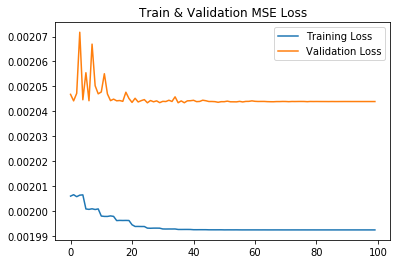

In [56]:
plt.title('Train & Validation MSE Loss')
plt.plot(train_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend()
plt.show()